## Mapping the Landscape of Generative AI Research Through Web of Science

#### Use Web of Science database to search for publications related to generative AI
#### Analytical approach focused on keyword co-occurrence networks derived from author keywords
#### Map the intellectual structure and identify the core themes and trends in generative AI research

## Task 1: Comprehensive Literature Retrieval

#### Defining my search terms: I want the search to be specifically on generative AI models, techniques, and applications. So my search terms are the following:
#### AK=("generative AI" OR "generative artificial intelligence" OR "generative adversarial network*" OR "GAN" OR "diffusion model*" OR "text-to-image" OR "text-to-video" OR "image generation" OR "generative transformer*" OR "foundation model*" OR "large language model*" OR "LLM" OR "text generation")
#### Since there are still 40,000+ documents, I will be limiting it by domain and searching only for "Materials Science Multidisciplinary" in the Web of Science category. Selected the document type as "Article", and selected years 2019-2023, also sorted by relevance

In [5]:
# parse txt files
import os
import pandas as pd

# define  a function to parse each txt file in the folder WoS txt files
def parse_wos_txt(filepath):
    records = []
    
    # open and read the text file content
    with open(filepath, 'r', encoding='utf-8') as file:
        content = file.read()

    # split the file into entries based on the delimiter ER which means End of Record
    raw_entries = content.split('\nER\n')

    # process each article and save the relevant information in a dictionary
    for entry in raw_entries:
        lines = entry.strip().split('\n')
        record = {
            "Title": "",
            "Year": "",
            "Author_Keywords": [],
            "Keywords_Plus": [],
            "Abstract": "",
            "Source_File": os.path.basename(filepath)
        }

        i = 0

        # go through each line in the article 
        while i < len(lines):
            line = lines[i]
            prefix = line[:2]

            # look for TI to save the title into the dictionary
            if prefix == 'TI':
                title_lines = [line[3:].strip()]
                i += 1
                while i < len(lines) and lines[i][:2] == '  ':
                    title_lines.append(lines[i].strip())
                    i += 1
                record["Title"] = ' '.join(title_lines)
                continue

            # look for PY to save the year into the dictionary
            elif prefix == 'PY':
                record["Year"] = line[3:].strip()

            # look for DE to save the author keywords into the dictionary
            elif prefix == 'DE':
                keywords = line[3:].strip().split(';')
                record["Author_Keywords"] = [k.strip() for k in keywords if k.strip()]

            # look for ID to save the keywords plus into the dictionary
            elif prefix == 'ID':
                keywords = line[3:].strip().split(';')
                record["Keywords_Plus"] = [k.strip() for k in keywords if k.strip()]

            # look for AB to save the abstract into the dictionary
            elif prefix == 'AB':
                abstract_lines = [line[3:].strip()]
                i += 1
                while i < len(lines) and lines[i][:2] == '  ':
                    abstract_lines.append(lines[i].strip())
                    i += 1
                record["Abstract"] = ' '.join(abstract_lines)
                continue

            i += 1

        # skip any empty records
        if record["Title"]:
            records.append(record)

    return records

# function to go through all txt files in the folder and combine their records
def parse_all_txt_files(folder_path):
    all_records = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            full_path = os.path.join(folder_path, filename)
            print(f"Parsing: {filename}")
            yearly_records = parse_wos_txt(full_path)
            all_records.extend(yearly_records)

    return all_records

# call the functions to WoS txt files
folder_path = "WoS txt files"
all_data = parse_all_txt_files(folder_path)
df = pd.DataFrame(all_data)

# show the first 5 rows
print(df.head())


Parsing: 2023.txt
Parsing: 2022.txt
Parsing: 2020.txt
Parsing: 2021.txt
Parsing: 2019.txt
                                               Title  Year  \
0  Conditional diffusion-based microstructure rec...  2023   
1  A Hybrid Deep Learning Framework Based on Diff...  2023   
2  Portrait Reification with Generative Diffusion...  2023   
3  Pixel-Level Grayscale Manipulation to Improve ...  2023   
4  Effect of material properties on the laser-ind...  2023   

                                     Author_Keywords  \
0  [Microstructure, Reconstruction, Diffusion mod...   
1  [structural health monitoring, diffusion model...   
2  [diffusion models, image generation, embedding...   
3  [additive manufacturing, digital light process...   
4  [Hydrogen, Tungsten, Laser-induced desorption,...   

                                       Keywords_Plus  \
0                                       [GENERATION]   
1                      [DAMAGE DETECTION, DIAGNOSIS]   
2                               

## Task 2: Keyword Co-Occurrence Network Analysis

#### Building a network or the nodes are the keywords and the edges are how often the two keywords appear together in the same article

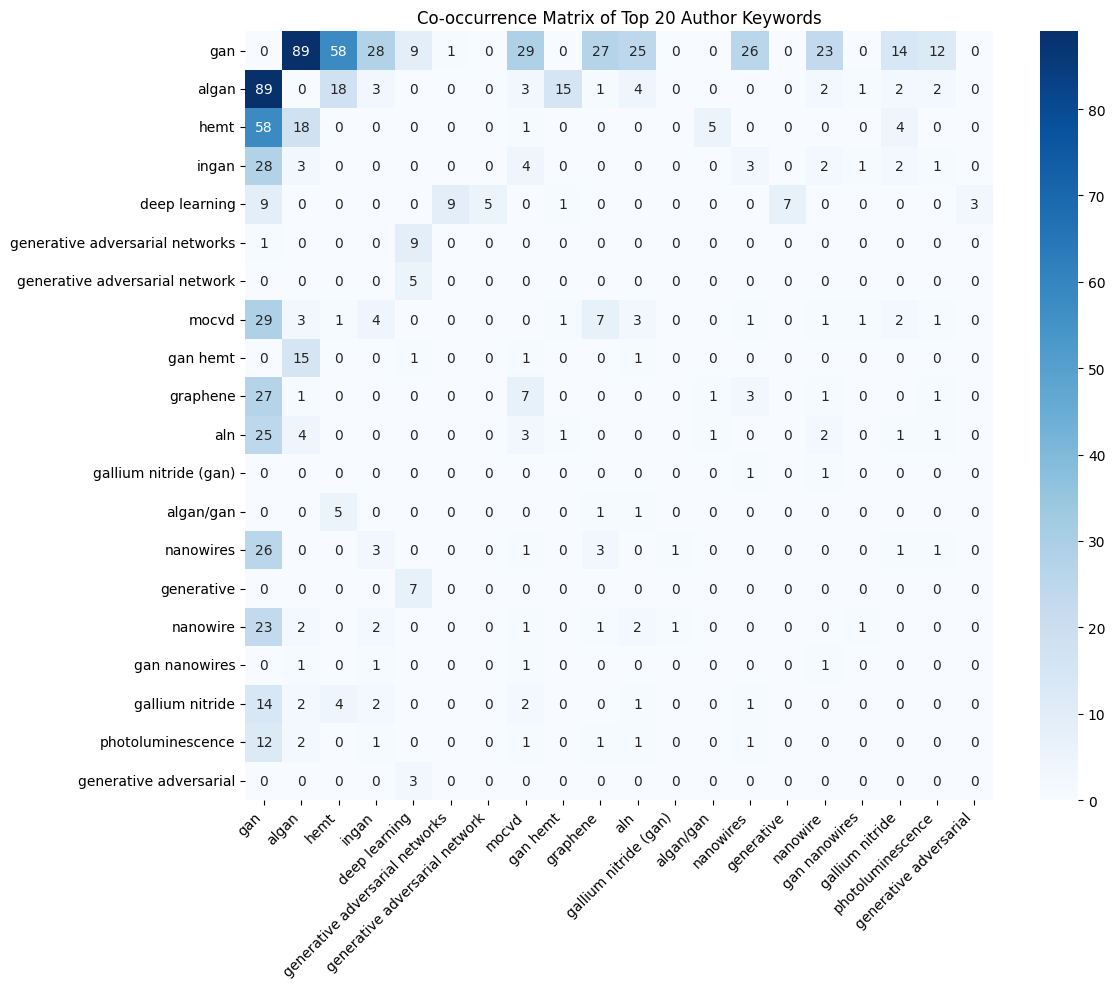

In [7]:
# Build the co-occurrence matrix
from collections import Counter
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

# Build co-occurrence counter and individual keyword frequency
co_occurrence_counter = Counter()
keyword_freq = Counter()

for keywords in df['Author_Keywords']:
    keywords = [k.lower().strip() for k in keywords]
    for combo in combinations(set(keywords), 2):
        co_occurrence_counter[tuple(sorted(combo))] += 1
    for kw in set(keywords):  # Count individual keyword frequency
        keyword_freq[kw] += 1

# Get top 20 most frequent keywords
top_keywords = [kw for kw, _ in keyword_freq.most_common(20)]

# Initialize co-occurrence matrix
matrix = pd.DataFrame(0, index=top_keywords, columns=top_keywords)

# Fill the matrix with co-occurrence counts
for (kw1, kw2), count in co_occurrence_counter.items():
    if kw1 in top_keywords and kw2 in top_keywords:
        matrix.at[kw1, kw2] = count
        matrix.at[kw2, kw1] = count  # make symmetric

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(matrix, cmap='Blues', annot=True, fmt='d')
plt.title('Co-occurrence Matrix of Top 20 Author Keywords')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

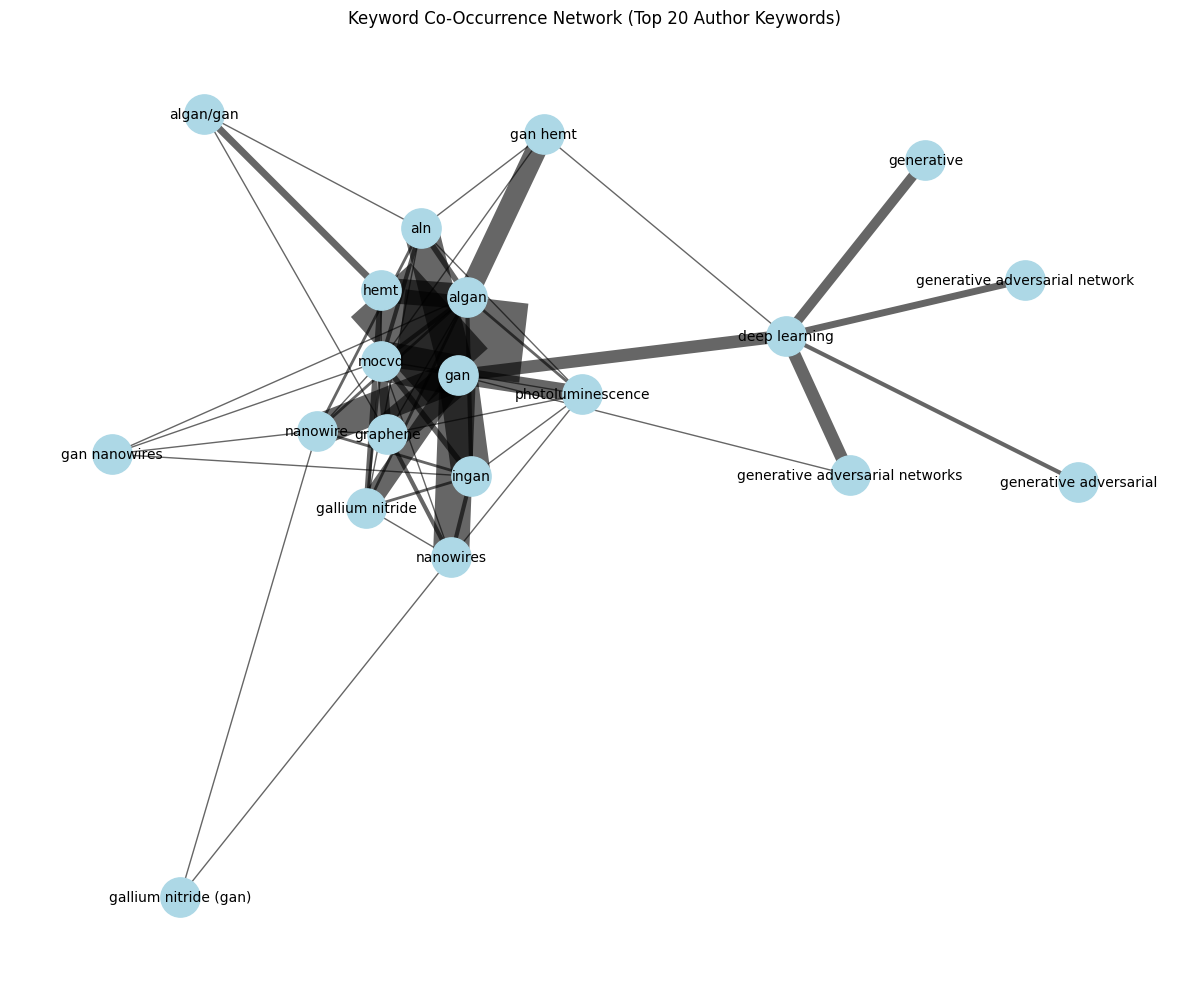

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a full graph from your co-occurrence counter
G = nx.Graph()
for (kw1, kw2), count in co_occurrence_counter.items():
    G.add_edge(kw1, kw2, weight=count)

# Create subgraph with only top 20 keywords
G_sub = G.subgraph(top_keywords)

# Draw the subgraph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_sub, seed=42)

# Edge weights for line thickness
edges = G_sub.edges(data=True)
weights = [data['weight'] for (_, _, data) in edges]

# Draw nodes, edges, labels
nx.draw_networkx_nodes(G_sub, pos, node_size=800, node_color='lightblue')
nx.draw_networkx_edges(G_sub, pos, width=weights, alpha=0.6)
nx.draw_networkx_labels(G_sub, pos, font_size=10)

plt.title("Keyword Co-Occurrence Network (Top 20 Author Keywords)")
plt.axis('off')
plt.tight_layout()
plt.show()


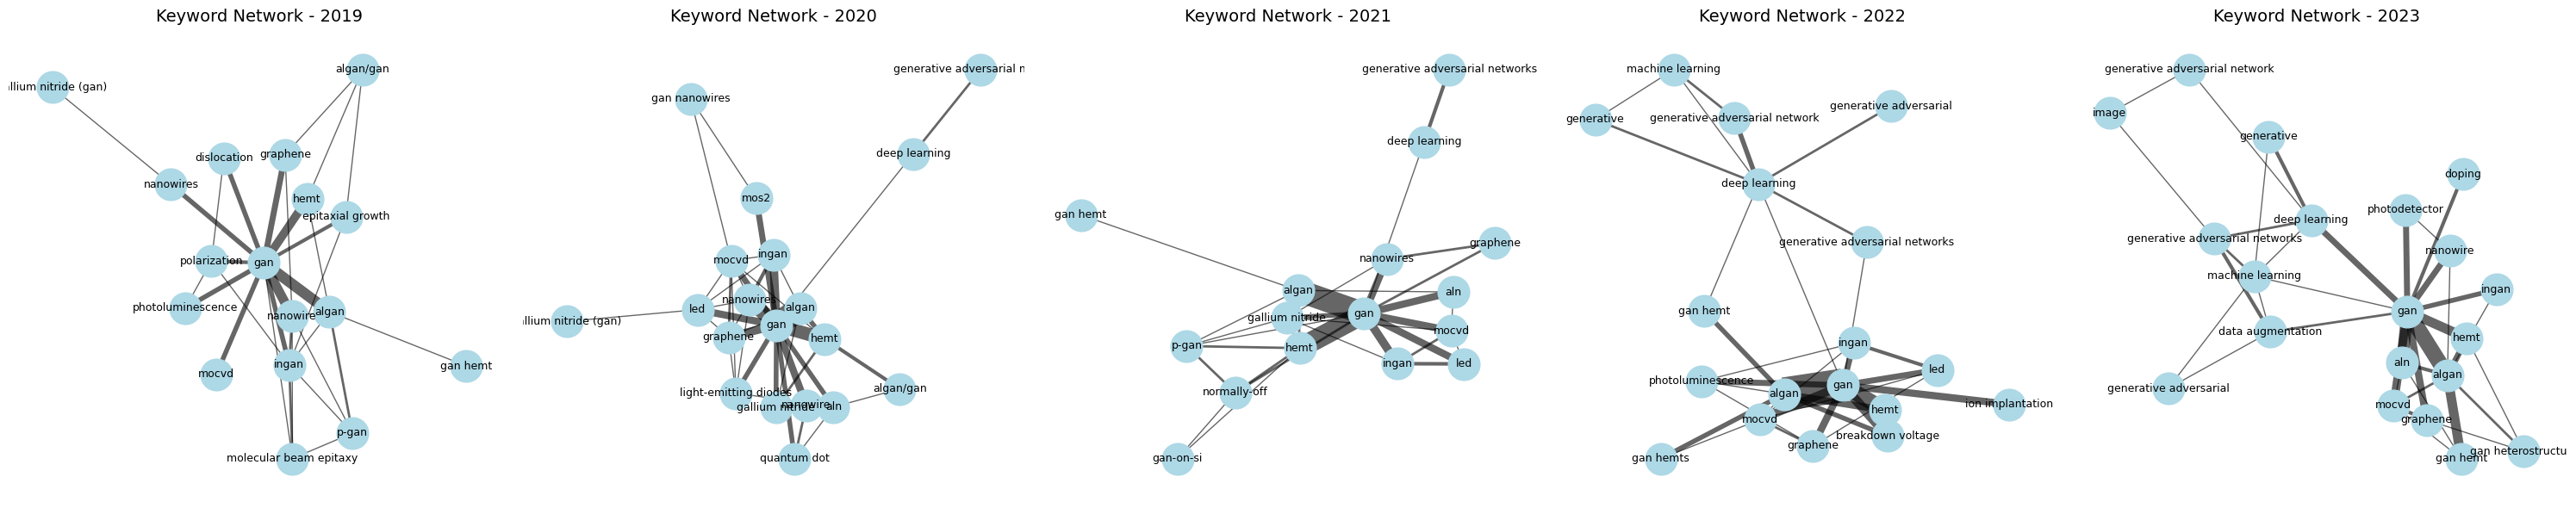

In [9]:
# draw network graph for top keywords per year
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter, defaultdict
from itertools import combinations
import ast

# create yearly counters
yearly_counters = defaultdict(Counter)
yearly_keyword_freq = defaultdict(Counter)

for _, row in df.iterrows():
    year = str(row["Year"])
    keywords = [kw.lower().strip() for kw in row['Author_Keywords']]
    for combo in combinations(set(keywords), 2):
        yearly_counters[year][tuple(sorted(combo))] += 1
    for kw in set(keywords):
        yearly_keyword_freq[year][kw] += 1

# prepare subplots
target_years = ['2019', '2020', '2021', '2022', '2023']
num_years = len(target_years)

# set up the subplot grid
fig, axes = plt.subplots(1, num_years, figsize=(6 * num_years, 6))
if num_years == 1:
    axes = [axes]

# loop through each year and plot
for i, year in enumerate(target_years):
    top_keywords = [kw for kw, _ in yearly_keyword_freq[year].most_common(20)]
    G = nx.Graph()

    # add filtered edges to graph
    for (kw1, kw2), count in yearly_counters[year].items():
        if kw1 in top_keywords and kw2 in top_keywords:
            G.add_edge(kw1, kw2, weight=count)

    pos = nx.spring_layout(G, seed=42)
    edge_weights = [data['weight'] for (_, _, data) in G.edges(data=True)]

    ax = axes[i]
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=700, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, ax=ax, width=edge_weights, alpha=0.6)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=9)
    ax.set_title(f"Keyword Network - {year}", fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()


#### Insights from yearly network graphs: in 2019-2021 material related words like nanowire dominate at the center of the network, while in 2022 and 2023, terms like generative adversarial network and deep learning gain prominence which shows the shift to AI techniques. Also in later years we see a cluster combining generative adversarial network, deep learning, and data augmentation which shows there is a more dominant focus on those keywords. Lastly, in 2023, GAN and deep learning have a relatively strong weights in co-occurrence which is not seen in earlier years. 

Top 5 keywords overall: ['gan', 'algan', 'hemt', 'ingan', 'deep learning']


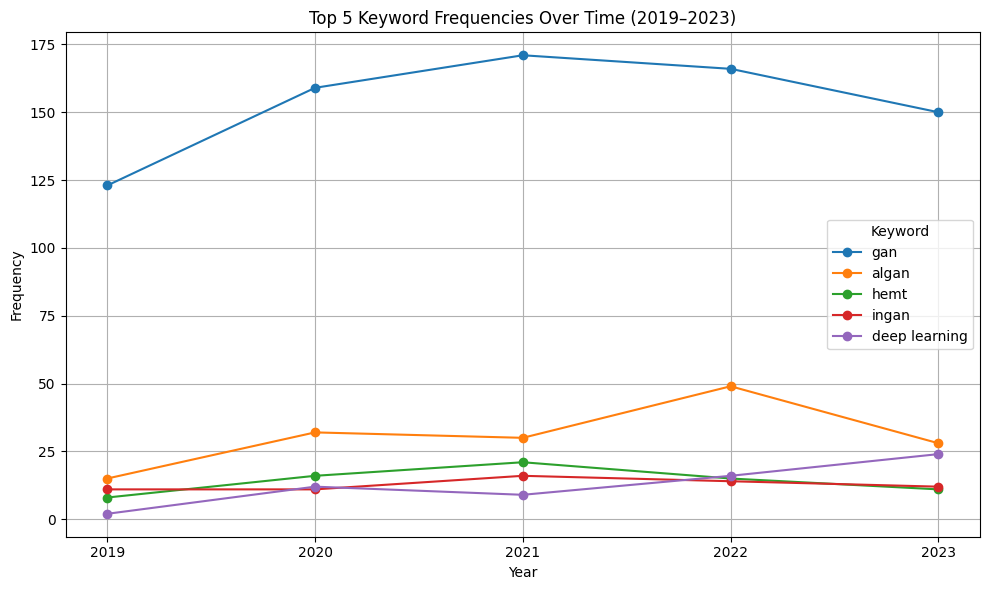

In [10]:
# Step 1: Get total keyword frequencies across all years
total_keyword_freq = Counter()
for year_counter in yearly_keyword_freq.values():
    total_keyword_freq.update(year_counter)

# Step 2: Identify the top 5 keywords overall
top_keywords = [kw for kw, _ in total_keyword_freq.most_common(5)]
print("Top 5 keywords overall:", top_keywords)

# Step 3: Prepare frequency data for plotting
target_years = ['2019', '2020', '2021', '2022', '2023']
freq_data = {
    kw: [yearly_keyword_freq[year].get(kw, 0) for year in target_years]
    for kw in top_keywords
}
freq_df = pd.DataFrame(freq_data, index=target_years)

# Step 4: Plot
plt.figure(figsize=(10, 6))
for kw in top_keywords:
    plt.plot(freq_df.index, freq_df[kw], marker='o', label=kw)

plt.title("Top 5 Keyword Frequencies Over Time (2019–2023)")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.legend(title="Keyword")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Interpretation of line graph: The top keywords reveal a clear blend of generative AI and semiconductor materials research. While terms like GAN and deep learning represent the growing influence of AI, keywords like AlGaN, HEMT, and InGaN suggest that a substantial portion of the generative research in this dataset is applied in materials science, optoelectronics, and transistor design. Regardless, as it can be seen, GAN is used more over time peaking in 2021 which is very interesting. Deep learning on the other hand has an upward trend.

## Task 3: Identification of Key Research Themes

#### Degree centrality is how connected a keyword is; betweenness cetrality is how often a keyword lies on paths between others; edge weights as seen before is how strongly two keywords co-occur

In [11]:
import networkx as nx

# create the full graph if not already done
G = nx.Graph()
for (kw1, kw2), weight in co_occurrence_counter.items():
    G.add_edge(kw1, kw2, weight=weight)

# compute centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')

# top 10 keywords by degree
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 by Degree Centrality:")
for kw, score in top_degree:
    print(f"{kw}: {score:.4f}")


Top 10 by Degree Centrality:
gan: 0.3698
algan: 0.0844
hemt: 0.0377
ingan: 0.0369
mocvd: 0.0324
deep learning: 0.0296
gan hemt: 0.0270
graphene: 0.0234
generative adversarial network: 0.0224
generative adversarial networks: 0.0216


In [13]:
# analyzing how a keywords degree relates to its strength
keyword_metrics = []

for node in G.nodes:
    degree = G.degree(node)
    strength = sum(G[node][nbr]['weight'] for nbr in G.neighbors(node))
    keyword_metrics.append({'keyword': node, 'degree': degree, 'strength': strength})

metrics_df = pd.DataFrame(keyword_metrics)
metrics_df['strength_per_connection'] = metrics_df['strength'] / metrics_df['degree']

# sort by strength
metrics_df.sort_values(by='strength', ascending=False).head(10)


,keyword,degree,strength,strength_per_connection
384,gan,1835,2967,1.616894
423,algan,419,641,1.529833
468,hemt,187,307,1.641711
538,ingan,183,251,1.371585
74,mocvd,161,220,1.366460
59,deep learning,147,190,1.292517
479,graphene,116,163,1.405172
419,gan hemt,134,154,1.149254
437,aln,100,139,1.390000
684,nanowire,86,129,1.500000


In [21]:
# analyzing how often papers mention different ML models throughout the years
ml_models = ['gan', 'vae', 'transformer', 'diffusion model', 'autoregressive model', 'gpt']
model_freq = {model: [] for model in ml_models}
years = ['2019', '2020', '2021', '2022', '2023']

for year in years:
    counter = yearly_keyword_freq[year]
    for model in ml_models:
        model_freq[model].append(counter.get(model, 0))

model_freq_df = pd.DataFrame(model_freq, index=years)
print(model_freq_df)


      gan  vae  transformer  diffusion model  autoregressive model  gpt
2019  123    0            0                4                     0    0
2020  159    0            0                5                     0    0
2021  171    0            1                5                     0    0
2022  166    0            1                3                     0    0
2023  150    0            0                4                     0    0


In [22]:
# looking for emerging keywords, where they were barely mentioned in earlier years but are now more popular
emerging = []
for kw in total_keyword_freq:
    if yearly_keyword_freq['2019'].get(kw, 0) == 0 and yearly_keyword_freq['2023'].get(kw, 0) >= 5:
        emerging.append((kw, yearly_keyword_freq['2023'][kw]))

# sort by 2023 frequency
emerging = sorted(emerging, key=lambda x: x[1], reverse=True)
print("Emerging Keywords:", emerging[:10])


Emerging Keywords: [('generative', 15), ('data augmentation', 9), ('image', 6), ('gan hemts', 5)]


In [23]:
# output top 50 keywords to a CSV file
top_50_keywords = total_keyword_freq.most_common(50)
top_50_df = pd.DataFrame(top_50_keywords, columns=['Keyword', 'Frequency'])
top_50_df.to_csv('top_50_keywords.csv', index=False)

#### Asked chatbot to categorize these 50 keywords:
##### Semiconductor Materials: gan, algan, ingan, graphene, sic, diamond
##### Device Technologies: hemt, gan hemt, power devices, led, uv led, uv photodetector
##### Deposition & Fabrication Techniques: mocvd, mbes, mbe, pld, atomic layer deposition
##### Machine Learning & AI: deep learning, generative adversarial networks, generative adversarial network, cnn, transfer learning, machine learning, ai
##### Simulation & Modeling: device simulation, tcad, finite element, modeling
##### Applications: sensors, photodetectors, electronics, optoelectronics, high frequency, high power, uv detection



/var/folders/qf/m5968pjn2nl3_n7rcxrcdfp40000gn/T/ipykernel_41576/1083226861.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = matrix.fillna(0).astype(int)


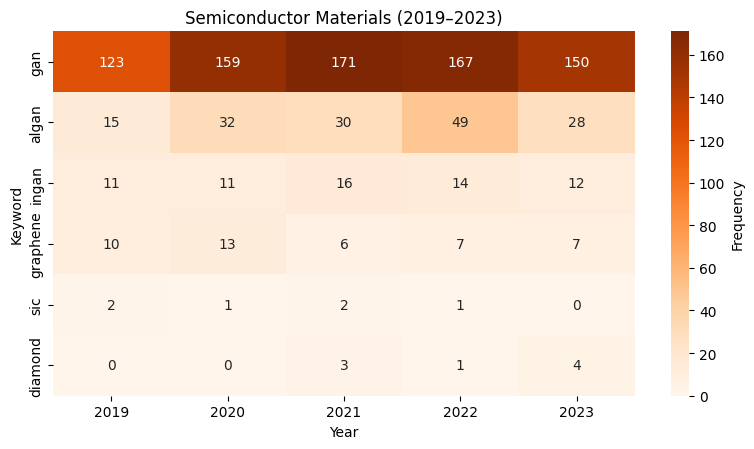

/var/folders/qf/m5968pjn2nl3_n7rcxrcdfp40000gn/T/ipykernel_41576/1083226861.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = matrix.fillna(0).astype(int)


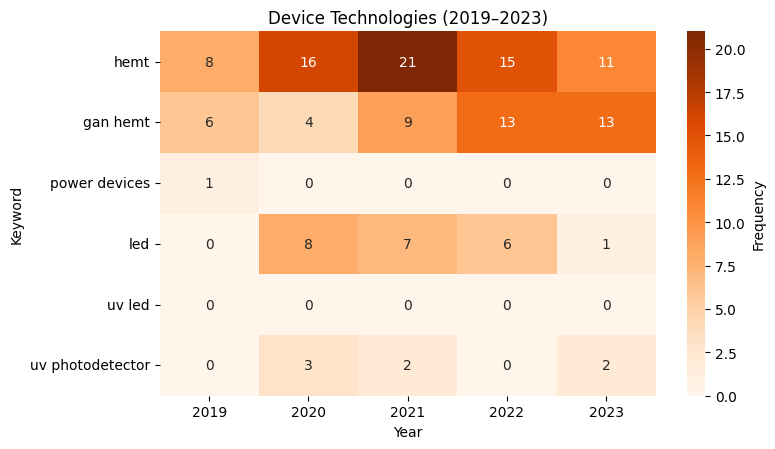

/var/folders/qf/m5968pjn2nl3_n7rcxrcdfp40000gn/T/ipykernel_41576/1083226861.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = matrix.fillna(0).astype(int)


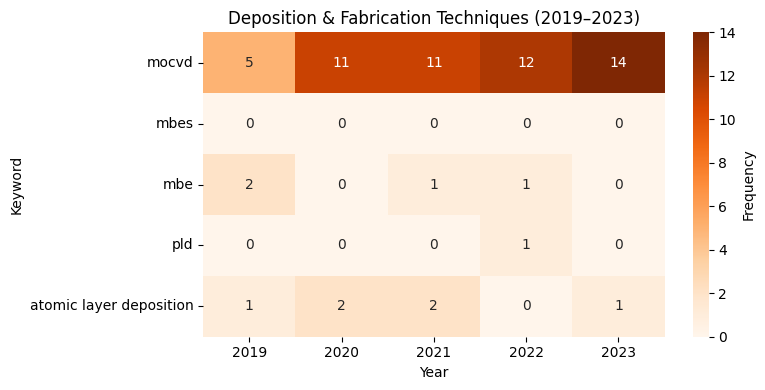

/var/folders/qf/m5968pjn2nl3_n7rcxrcdfp40000gn/T/ipykernel_41576/1083226861.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = matrix.fillna(0).astype(int)


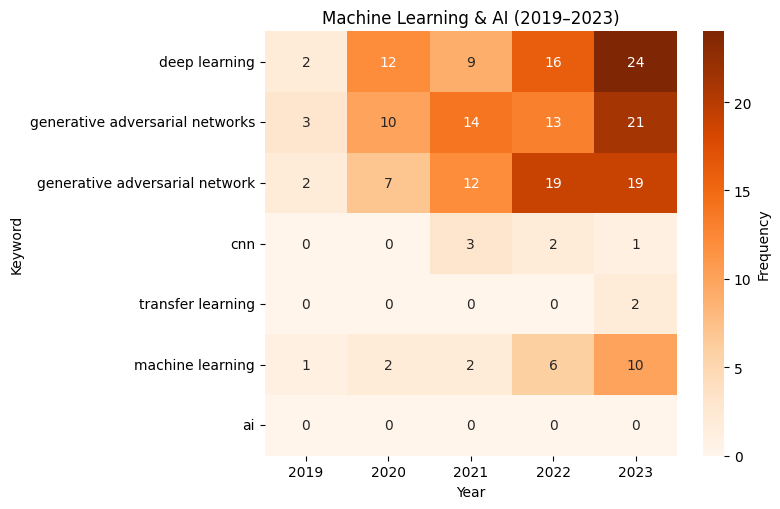

/var/folders/qf/m5968pjn2nl3_n7rcxrcdfp40000gn/T/ipykernel_41576/1083226861.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = matrix.fillna(0).astype(int)


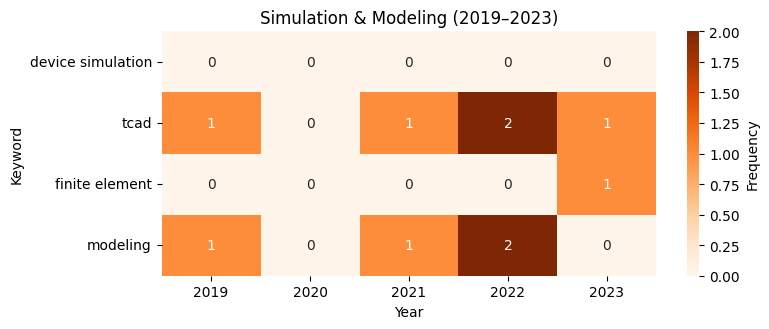

/var/folders/qf/m5968pjn2nl3_n7rcxrcdfp40000gn/T/ipykernel_41576/1083226861.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = matrix.fillna(0).astype(int)


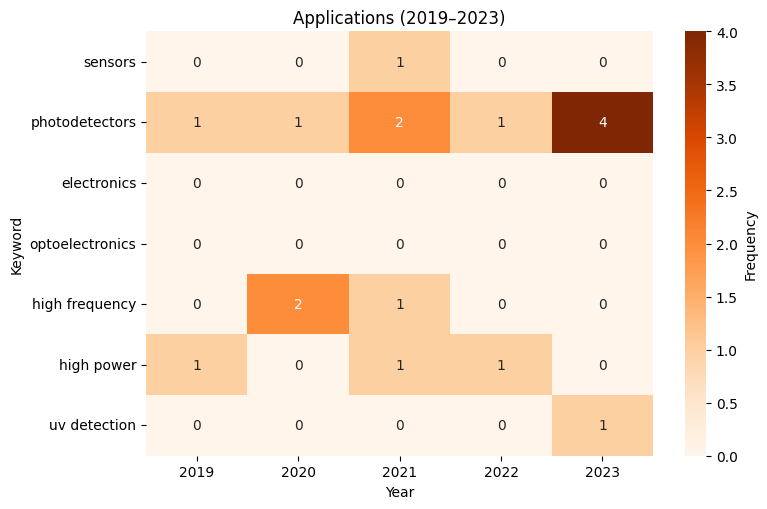

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

# lowercase all keywords
yearly_keyword_freq = defaultdict(Counter)

for _, row in df.iterrows():
    year = str(row["Year"])
    keywords = [kw.lower().strip() for kw in row["Author_Keywords"]]
    for kw in keywords:
        yearly_keyword_freq[year][kw] += 1

# AI chatbot keyword categories
category_keywords = {
    "Semiconductor Materials": ["gan", "algan", "ingan", "graphene", "sic", "diamond"],
    "Device Technologies": ["hemt", "gan hemt", "power devices", "led", "uv led", "uv photodetector"],
    "Deposition & Fabrication Techniques": ["mocvd", "mbes", "mbe", "pld", "atomic layer deposition"],
    "Machine Learning & AI": ["deep learning", "generative adversarial networks", "generative adversarial network", "cnn", "transfer learning", "machine learning", "ai"],
    "Simulation & Modeling": ["device simulation", "tcad", "finite element", "modeling"],
    "Applications": ["sensors", "photodetectors", "electronics", "optoelectronics", "high frequency", "high power", "uv detection"]
}

years = ['2019', '2020', '2021', '2022', '2023']

# generate a heatmap for each category
for category, keywords in category_keywords.items():
    matrix = pd.DataFrame(index=keywords, columns=years)
    for year in years:
        for kw in keywords:
            matrix.at[kw, year] = yearly_keyword_freq[year].get(kw, 0)
    matrix = matrix.fillna(0).astype(int)

    # Plot heatmap
    plt.figure(figsize=(8, 0.6 * len(keywords) + 1))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Oranges', cbar_kws={'label': 'Frequency'})
    plt.title(f"{category} (2019–2023)")
    plt.xlabel("Year")
    plt.ylabel("Keyword")
    plt.tight_layout()
    plt.show()
